# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from tqdm import tnrange
import itertools
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


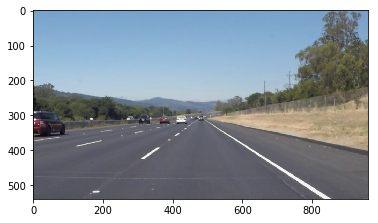

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
def filter_white_yellow_pixels(img, white_threshold=190, yellow_hsv_low=np.array([20,100,100]), yellow_hsv_high=np.array([40,255,255])):
    """
    Applies a filter to the image so that only white and yellow pixel remain, 
    the rest is set to black.
    
    Returns the filtered image.
    """
    # White pixel mask using RGB
    white_low = np.array([white_threshold]*3)
    white_high = np.array([255, 255, 255])
    white_mask = cv2.inRange(img, white_low, white_high)
    
    # Yellow pixel mask using HSV
    hsv_img = cv2.cvtColor(img[:,:,::-1], cv2.COLOR_BGR2HSV)
    yellow_mask = cv2.inRange(hsv_img, yellow_hsv_low, yellow_hsv_high)
    
    # Apply masks on image
    white_img = cv2.bitwise_and(img, img, mask=white_mask)
    yellow_img = cv2.bitwise_and(img, img, mask=yellow_mask)

    # Add both masked images into one
    filtered_img = cv2.addWeighted(white_img, 1., yellow_img, 1., 0.)

    return filtered_img

In [5]:
def calc_lane_x_cords(x1_sum, x2_sum, n, last_x1, last_x2, change_to_last):
    """
    Calculates the weighted average of x coordinates given the sum of the coordinates and the sum of weights (n)
    Additionally, the last x coordinates are considered as a baseline and combined using the "change_to_last" parameter"
    If no x coordinates are supplied, the old values are used.
    
    Formula: x = change_to_last * avg_x + (1 - change_to_last) * last_x
    Returns the new x as well as updates last_x coordinates
    """
    if n > 0:
        x1 = x1_sum / n
        x2 = x2_sum / n
        if last_x1 is not None and last_x2 is not None:
            x1 = change_to_last * x1 + (1-change_to_last) * last_x1
            x2 = change_to_last * x2 + (1-change_to_last) * last_x2
        last_x1 = x1
        last_x2 = x2
        x1 = int(np.around(x1))
        x2 = int(np.around(x2))
    elif last_x1 is not None and last_x2 is not None:
        x1 = int(np.around(last_x1))
        x2 = int(np.around(last_x2))
    else:
        return (None,)*4
    return x1, x2, last_x1, last_x2

def draw_solid_lines(img, lines, y_lim=0, last_lanes=(None,)*4, slope_thres=0.4, change_to_last=0.3, color=[255, 0, 0], thickness=10):
    """
    Draws two solid lines (one for left and one for right) onto image "img"
    All lines in "lines" are first separated by their slope where horizontal lines having an absolute slope smaller than "slope_thres" are discarded. 
        - Positive slope lines are considered to be part of the right lane.
        - Negative slope lines are considered to be part of the left lane.
    Then the lines are extended and their intersections with the bottom end the image (y = img.shape[0]) and with y = "y_lim" are calculated
    The resulting x coordinates for these intersections are averaged to get the average lane lines for each side
    While averaging each line is linearly weighted by its length so that long lines contibutes more to the resulting lane
    Finally, previous lane line coordinates can be passed via "last_lanes" in order to change these lines only by a ratio "change_to_last"
    Providing "last_lanes" gives exponentially smoothed lines according to previous lines.
    
    Lane lines are drawed on top of "img" and lane x coordinates are returned to be used as "last_lanes" in the next call
    """
    
    last_x1_right, last_x2_right, last_x1_left, last_x2_left = last_lanes
    
    x1_sum_right = x2_sum_right = n_right = 0
    x1_sum_left  = x2_sum_left  = n_left  = 0
        
    for line in lines:
        for x1,y1,x2,y2 in line:
            # ignore vertical lines
            if x1 != x2:
                slope = (y2-y1)/(x2-x1)
                # discard horizontal lines (depending on slope_thres parameter)
                if np.abs(slope) > slope_thres:
                    # length of line is used as a weighting (long lines contribute more towards the final lane)
                    length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
                    # find intersections with horizontal lines at bottom of the image and top of drawing area
                    b = y1 - x1 * slope
                    x_top = (y_lim - b) / slope
                    x_bottom = (img.shape[0] - b) / slope
                    # classify lines depending on slope: positive are right lane, negative are left lane
                    if slope > 0:
                        x1_sum_right += x_top * length
                        x2_sum_right += x_bottom * length
                        n_right += length
                    else:
                        x1_sum_left += x_top * length
                        x2_sum_left += x_bottom * length
                        n_left += length
        
    # calculate and draw right lane
    x1, x2, last_x1_right, last_x2_right = calc_lane_x_cords(x1_sum_right, x2_sum_right, n_right,
                                                             last_x1_right, last_x2_right, change_to_last)
    if x1 is not None and x2 is not None:
        cv2.line(img, (x1, y_lim), (x2, img.shape[0]), color, thickness)

    # calculate and draw left lane
    x1, x2, last_x1_left, last_x2_left = calc_lane_x_cords(x1_sum_left, x2_sum_left, n_left,
                                                           last_x1_left, last_x2_left, change_to_last)
    if x1 is not None and x2 is not None:
        cv2.line(img, (x1, y_lim), (x2, img.shape[0]), color, thickness)
    
    return last_x1_right, last_x2_right, last_x1_left, last_x2_left

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [7]:
def detect_lane_lines(image, vertices, ks, lt, ht, rho, theta, thres, mll, mlg):
    """
    Minimal pipeline for detecting lane lines and returning the hough lines
    It is applied in order:
        - Gaussian Blur, parameter: ks -> kernel size
        - White yellow filter
        - Grayscaling
        - Canny edge detection, parameters: lt -> low_threshold, ht -> high_threshold
        - Masking of region of interest: parameters: vertices
        - Hough transform, parameters: rho, theta, thres, mll -> min_line_len, mlg -> max_line_gap
        
    Returns hough lines as well as canny edge detection image used for hyperparameter search
    """
    # Apply Gaussian smoothing
    blur = gaussian_blur(image, ks)
    
    # Filiter white/yellow color
    white_yellow = filter_white_yellow_pixels(blur)

    # Grayscale the image
    gray = grayscale(white_yellow)
                        
    # Apply Canny edge detection
    edges = canny(gray, lt, ht)

    # Mask line image
    masked_edges = region_of_interest(edges, vertices)

    # Apply Hough transform
    lines = hough_lines(masked_edges, rho, theta, thres, mll, mlg)
    
    return lines, edges

In [8]:
def lane_detection_pipeline(image, vertices, detect_lane_parameters, draw_solid=True, **draw_lines_params):
    """
    Full lane detection pipeline that calls "detect_lane_lines" with "detect_lane_parameters" 
    and then draws the resulting lane lines.
    When "draw_solid" is False then hough lines are drawn, otherwise the extended solid lines are drawn.
    
    Returns image with lane lines overlay
    """
    lines, edges = detect_lane_lines(image, vertices, *detect_lane_parameters)
    
    # Create image and draw lines on it
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    if draw_solid:
        draw_solid_lines(line_img, lines, **draw_lines_params)
    else:
        draw_lines(line_img, lines)

    # Merge line image with original image
    image_line_overlay = weighted_img(line_img, image)
        
    return image_line_overlay

### Parameter Specification

In [9]:
# Fixed parameters
directory = "test_images/"
# Parameters of region of interest
lane_height = 0.4 # relative image size
lane_top_width = 0.1 # relative image size

def get_vertices(imshape, area="lanes"):
    areas = ["lanes", "quarter"]
    if area not in areas:
        area = "lanes"
        print("Unknown 'area' argument, using default value: '{0}'.".format(areas[0]))
    
    if area == areas[0]:
        vertices = np.array([[(0,imshape[0]), (imshape[1]*(0.5-lane_top_width/2), imshape[0]*(1-lane_height)), (imshape[1]*(0.5+lane_top_width/2), imshape[0]*(1-lane_height)), (imshape[1],imshape[0])]], dtype=np.int32)
    elif area == areas[1]:
        vertices = np.array([[(0,imshape[0]), (imshape[1]/2, imshape[0]/2), (imshape[1],imshape[0])]], dtype=np.int32)

    return vertices

In [10]:
# Parameters for grid search
kernel_size = [3, 5, 7]
low_threshold_list = [75, 100, 125]
high_threshold_list = [150, 200, 250]

rho_list = [0.5, 1, 2]
theta_list = [np.pi/180, np.pi/270, np.pi/360]
threshold_list = [10, 15, 20]
min_line_len_list = [20, 30, 40, 50, 60]
max_line_gap_list = [20, 30, 40, 50]

parameters = list(itertools.product(kernel_size, low_threshold_list, high_threshold_list, 
                                    rho_list, theta_list, threshold_list, min_line_len_list, max_line_gap_list))

### Hyperparameter grid search

In [11]:
"""
Grid search for hyperparameters
Every combination of hyperparameters is evaluation with two measures:
    1. Ratio of hough line pixel in the region of interest vs hough line pixel of an extended region
    2. Ratio of hough line pixel in the region of interest vs maximum hough line pixel in the same region amoung parameters
    
The 1. measure is high when the algorithm only detects lane lines and not other objects (e.g. cars) in the extended region
The 2. measure is high when as much lines as possible are detected in the lane region of interest
A good combination of both measures ensures that the algorithm detects most of the lane features whereas minimizing unecessary features

ATTENTION: This cell takes a long time to complete. You can skip this cell and use the precomputed results in the next cell.
"""
files = os.listdir(directory)
pixel_lane_mask = np.zeros((len(files), len(parameters)))
pixel_quarter_mask = np.zeros((len(files), len(parameters)))

# Run grid search
for fi in tnrange(len(files), desc="Images", leave=True):
    file_name = directory + files[fi]
    image = mpimg.imread(file_name)
    
    lanes_vetices = get_vertices(image.shape, "lanes")
    quarter_vetices = get_vertices(image.shape, "quarter")
    
    for pi in tnrange(len(parameters), desc="Params", leave=False):
        lines_lanes, edges = detect_lane_lines(image, lanes_vetices, *parameters[pi])
        
        # Reuse precomputed edges image to speed up computation
        masked_edges_quarter = region_of_interest(edges, quarter_vetices)
        lines_quarter = hough_lines(masked_edges_quarter, *parameters[pi][-5:])
        
        line_image_lanes = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        line_image_quarter = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        
        draw_lines(line_image_lanes, lines_lanes)
        pixel_lane_mask[fi,pi] = np.sum(line_image_lanes/255)
        
        draw_lines(line_image_quarter, lines_quarter)
        pixel_quarter_mask[fi,pi] = np.sum(line_image_quarter/255)
        

#Calculate measures and evaluate them by weighting them with lambda and (1-lambda) respectively
lane_quarter_ratio = np.mean(pixel_lane_mask / pixel_quarter_mask, axis=0)

max_lane_pixel = np.max(pixel_lane_mask, axis=1)
lane_pixel_ratio = np.mean(pixel_lane_mask / max_lane_pixel[:,None], axis=0)

print("Lambda\tL/Q\tL/maxL\tScore\tParameters")
arg_list = []
parameter_list = []
for la in np.arange(0,1.1,0.1):
    score = la * lane_quarter_ratio + (1 - la) * lane_pixel_ratio
    arg_best_score = np.argsort(score)[-1]
    if parameters[arg_best_score] not in parameter_list:
        parameter_list.append(parameters[arg_best_score])
    print(la, 
          "\t%.3f" % lane_quarter_ratio[arg_best_score], 
          "\t%.3f" % lane_pixel_ratio[arg_best_score], 
          "\t%.3f" % score[arg_best_score], 
          "\t"+str(parameters[arg_best_score]))


Lambda	L/Q	L/maxL	Score	Parameters
0.0 	0.969 	0.963 	0.963 	(3, 75, 200, 0.5, 0.017453292519943295, 10, 20, 50)
0.1 	0.969 	0.963 	0.964 	(3, 75, 200, 0.5, 0.017453292519943295, 10, 20, 50)
0.2 	0.969 	0.963 	0.964 	(3, 75, 200, 0.5, 0.017453292519943295, 10, 20, 50)
0.3 	0.969 	0.963 	0.965 	(3, 75, 200, 0.5, 0.017453292519943295, 10, 20, 50)
0.4 	0.984 	0.953 	0.965 	(3, 75, 200, 0.5, 0.017453292519943295, 10, 40, 50)
0.5 	1.065 	0.888 	0.976 	(3, 125, 250, 1, 0.011635528346628864, 20, 40, 50)
0.6 	1.065 	0.888 	0.994 	(3, 125, 250, 1, 0.011635528346628864, 20, 40, 50)
0.7 	1.065 	0.888 	1.012 	(3, 125, 250, 1, 0.011635528346628864, 20, 40, 50)
0.8 	1.092 	0.802 	1.034 	(5, 75, 150, 2, 0.011635528346628864, 15, 50, 50)
0.9 	1.134 	0.632 	1.084 	(7, 125, 150, 2, 0.011635528346628864, 20, 60, 20)
1.0 	1.134 	0.632 	1.134 	(7, 125, 150, 2, 0.011635528346628864, 20, 60, 20)


**After trying out the 5 different parameter combination coming out of grid search I decided to use the first.
All of the combination have a good value for the 1. measure. This is because of the white-yellow-filter already removes unnecessary features. Running the grid search without the color filtering gives different parameter combinations where the 1. measure is much more important to take into account.**

In [12]:
# Using the values explicitly so that grid search does not need to be run every time
hyperparameters = (3, 75, 200, 0.5, 0.017453292519943295, 10, 20, 50)

### Test on Images

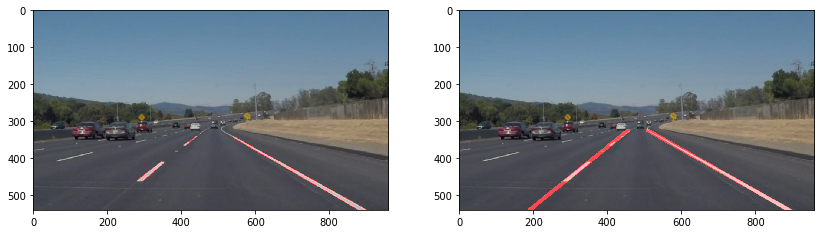

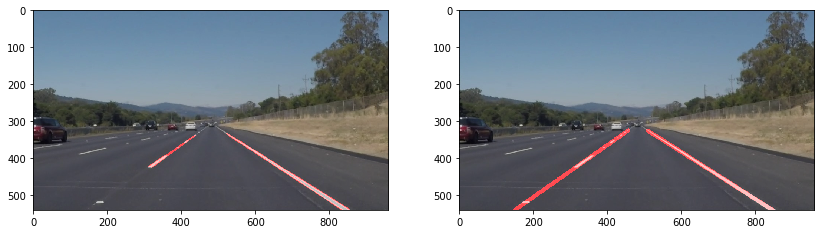

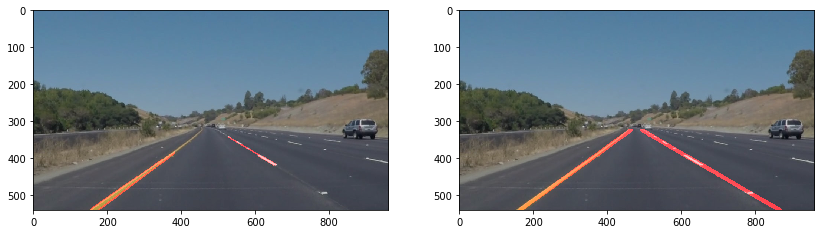

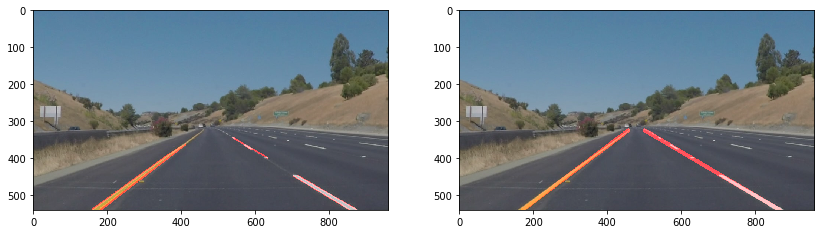

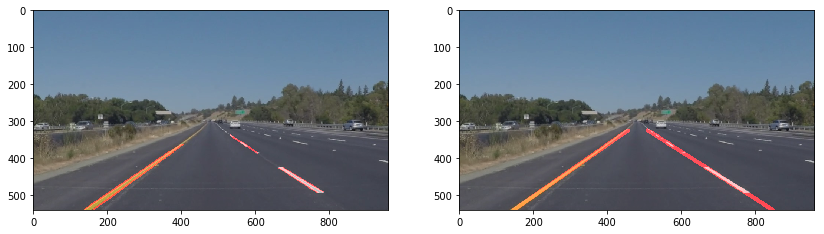

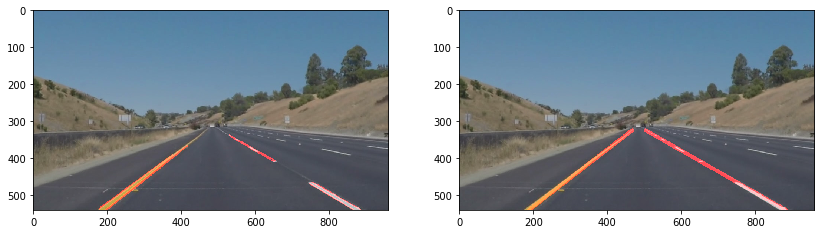

In [13]:
files = os.listdir(directory)

for fi in range(len(files)):
    if files[fi][0] == ".":
        continue
    
    file_name = directory + files[fi]
    image = mpimg.imread(file_name)
    
    vertices = get_vertices(image.shape, "lanes")
    lane_image = lane_detection_pipeline(image, vertices, hyperparameters, False)
    lane_image_solid = lane_detection_pipeline(image, vertices, hyperparameters, True, y_lim=vertices[0][1][1])
        
    fig = plt.figure(figsize=(14,8))
    fig.add_subplot(1,2,1)
    plt.imshow(lane_image)
    fig.add_subplot(1,2,2)
    plt.imshow(lane_image_solid)
    plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
class ImageProcessor:
    def __init__(self, draw_solid=True, slope_thres=0.4, change_to_last=0.3):
        self.last_lanes = (None,)*4
        self.draw_solid = draw_solid
        self.st = slope_thres
        self.ctl = change_to_last

    def __call__(self, image):
        vertices = get_vertices(image.shape)
        lines, _ = detect_lane_lines(image, vertices, *hyperparameters)
        
        line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        if self.draw_solid:
            self.last_lanes = draw_solid_lines(line_img, lines, y_lim=vertices[0][1][1], last_lanes=self.last_lanes, slope_thres=self.st, change_to_last=self.ctl)
        else:
            draw_lines(line_img, lines)
        
        image_line_overlay = weighted_img(line_img, image)
        return image_line_overlay

Let's try the one with the solid white lane on the right first ...

In [16]:
input_dir = "videos/"
output_dir = "videos_lanes/"

In [17]:
white_output = output_dir + 'solidWhiteRight_houghlines.mp4'
clip1 = VideoFileClip(input_dir + "solidWhiteRight.mp4")
white_clip = clip1.fl_image(ImageProcessor(False)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video videos_lanes/solidWhiteRight_houghlines.mp4
[MoviePy] Writing video videos_lanes/solidWhiteRight_houghlines.mp4


100%|█████████▉| 221/222 [00:14<00:00, 14.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_lanes/solidWhiteRight_houghlines.mp4 

CPU times: user 9.59 s, sys: 440 ms, total: 10 s
Wall time: 16.4 s


In [18]:
white_output = output_dir + 'solidWhiteRight_solidlines.mp4'
clip1 = VideoFileClip(input_dir + "solidWhiteRight.mp4")
white_clip = clip1.fl_image(ImageProcessor())
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video videos_lanes/solidWhiteRight_solidlines.mp4
[MoviePy] Writing video videos_lanes/solidWhiteRight_solidlines.mp4


100%|█████████▉| 221/222 [00:13<00:00, 17.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_lanes/solidWhiteRight_solidlines.mp4 

CPU times: user 8.8 s, sys: 430 ms, total: 9.23 s
Wall time: 14.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [20]:
yellow_output = output_dir + 'solidYellowLeft_houghlines.mp4'
clip2 = VideoFileClip(input_dir + "solidYellowLeft.mp4")
yellow_clip = clip2.fl_image(ImageProcessor(False))
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video videos_lanes/solidYellowLeft_houghlines.mp4
[MoviePy] Writing video videos_lanes/solidYellowLeft_houghlines.mp4


100%|█████████▉| 681/682 [00:39<00:00, 17.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_lanes/solidYellowLeft_houghlines.mp4 

CPU times: user 25 s, sys: 1.23 s, total: 26.2 s
Wall time: 41.3 s


In [21]:
yellow_output = output_dir + 'solidYellowLeft_solidlines.mp4'
clip2 = VideoFileClip(input_dir + 'solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(ImageProcessor())
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video videos_lanes/solidYellowLeft_solidlines.mp4
[MoviePy] Writing video videos_lanes/solidYellowLeft_solidlines.mp4


100%|█████████▉| 681/682 [00:38<00:00, 16.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_lanes/solidYellowLeft_solidlines.mp4 

CPU times: user 24.9 s, sys: 1.04 s, total: 25.9 s
Wall time: 40.3 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [23]:
chal_output = output_dir + 'challenge_houghlines.mp4'
clip3 = VideoFileClip(input_dir + "challenge.mp4")
challenge_clip = clip3.fl_image(ImageProcessor(False))
%time challenge_clip.write_videofile(chal_output, audio=False)

[MoviePy] >>>> Building video videos_lanes/challenge_houghlines.mp4
[MoviePy] Writing video videos_lanes/challenge_houghlines.mp4


100%|██████████| 251/251 [00:31<00:00,  7.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_lanes/challenge_houghlines.mp4 

CPU times: user 17 s, sys: 720 ms, total: 17.7 s
Wall time: 34.5 s


In [24]:
challenge_output = output_dir + 'challenge_solidlines.mp4'
clip2 = VideoFileClip(input_dir + 'challenge.mp4')
challenge_clip = clip2.fl_image(ImageProcessor())
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video videos_lanes/challenge_solidlines.mp4
[MoviePy] Writing video videos_lanes/challenge_solidlines.mp4


100%|██████████| 251/251 [00:32<00:00,  8.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_lanes/challenge_solidlines.mp4 

CPU times: user 17.2 s, sys: 1.1 s, total: 18.3 s
Wall time: 35.6 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))